In [50]:
%load_ext autoreload
%autoreload 2

import networkx as nx
import numpy as np
import pandas as pd
from krxns.net_construction import construct_reaction_network, extract_compounds
from krxns.config import filepaths
from krxns.utils import str2int
from krxns.cheminfo import draw_reaction, draw_molecule, standardize_smiles, expand_paired_cofactors
from krxns.networks import SuperMultiDiGraph
import json
from IPython.display import SVG
from itertools import chain

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [51]:
# Load unpaired cofactors
with open(filepaths['cofactors'] / 'expanded_unpaired_cofactors.json', 'r') as f:
    unpaired_cofactors = json.load(f)

# Load cc sim mats
cc_sim_mats = {
    'mcs': np.load(filepaths['sim_mats'] / "mcs.npy"),
    'tanimoto': np.load(filepaths['sim_mats'] / "tanimoto.npy")
}

# Load known reaction data
with open(filepaths['data'] / 'sprhea_240310_v3_mapped.json', 'r') as f:
    krs = json.load(f)

# Load op connected reactions
with open(filepaths['connected_reactions'] / 'sprhea_240310_v3_mapped_operator.json', 'r') as f:
    op_cxns = str2int(json.load(f))

# Load sim connected reactions
with open(filepaths['connected_reactions'] / 'sprhea_240310_v3_mapped_similarity.json', 'r') as f:
    sim_cxn = str2int(json.load(f))

with open(filepaths['connected_reactions'] / 'sprhea_240310_v3_mapped_side_counts.json', 'r') as f:
    side_counts = str2int(json.load(f))


# Load coreactant whitelist
with open(filepaths['cofactors'] / 'pickaxe_whitelist.json', 'r') as f:
    coreactant_whitelist = json.load(f)


# Get known compounds
kcs, smi2id = extract_compounds(krs)

In [68]:
G = SuperMultiDiGraph()
edges, nodes = construct_reaction_network(
    operator_connections=op_cxns,
    similarity_connections=sim_cxn,
    side_counts=side_counts,
    reactions=krs,
    unpaired_cofactors=unpaired_cofactors,
    connect_nontrivial=False,
    # atom_lb=0.6,
    coreactant_whitelist=coreactant_whitelist
)
G.add_nodes_from(nodes)
G.add_edges_from(edges)

In [69]:
def show_path(source, target, topk = 1):
    node_path, edge_path = G.shortest_path(source, target)
    for i, step in enumerate(edge_path):
        print(f"STEP #{i+1}")
        for edge in step[:topk]:
            print([(k, v) for k, v in edge.items() if k != 'smarts'])
            display(SVG(draw_reaction(edge['smarts'])))

STEP #1
[('rid', 1174), ('rhea_ids', [12654, 18366]), ('imt_rules', None), ('weight', 1), ('requires', {'NC(=O)C1=CN(C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4cnc5c(N)ncnc54)C(O)C3O)C(O)C2O)C=CC1': 1, 'O=C=O': 1}), ('other_products', {'NC(=O)c1ccc[n+](C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4cnc5c(N)ncnc54)C(O)C3O)C(O)C2O)c1': 1})]


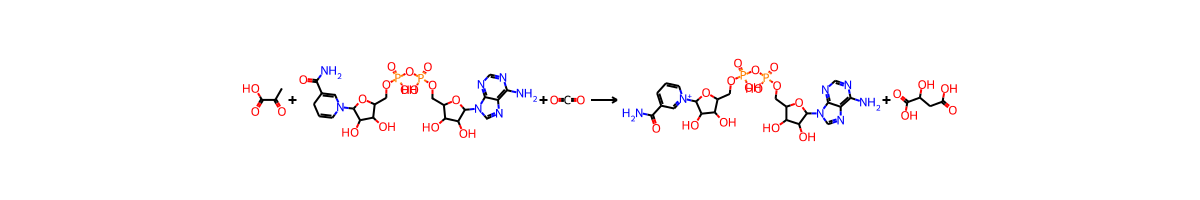

STEP #2
[('rid', 51), ('rhea_ids', [12462, 23694]), ('imt_rules', ['rule0020_18']), ('weight', 1.0), ('requires', {}), ('other_products', {'O': 1})]


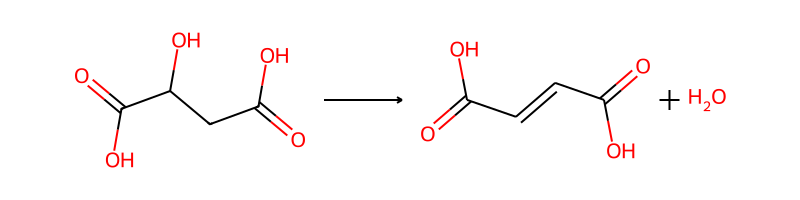

STEP #3
[('rid', 1638), ('rhea_ids', [40524]), ('imt_rules', ['rule0420_1']), ('weight', 1.0), ('requires', {'*c1c(*)c(O)c(*)c(*)c1O': 1}), ('other_products', {'*C1=C(*)C(=O)C(*)=C(*)C1=O': 1})]


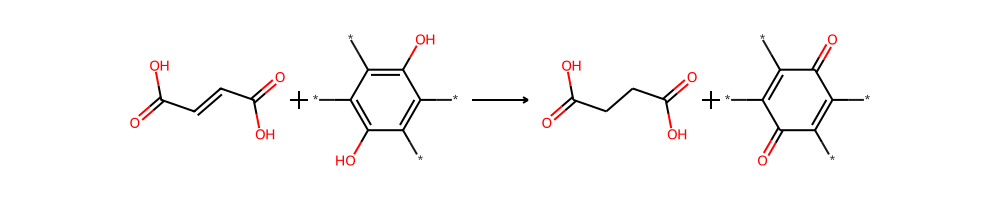

In [70]:
i = G.get_nodes_by_prop('name', 'pyruvate')[0]
j  = G.get_nodes_by_prop('name', 'succinate')[0]
show_path(i, j)

STEP #1
[('rid', 485), ('rhea_ids', [16811, 57506]), ('imt_rules', ['rule0051_08']), ('weight', 0.5714285714285714), ('requires', {'CC(=O)C(=O)O': 1}), ('other_products', {})]


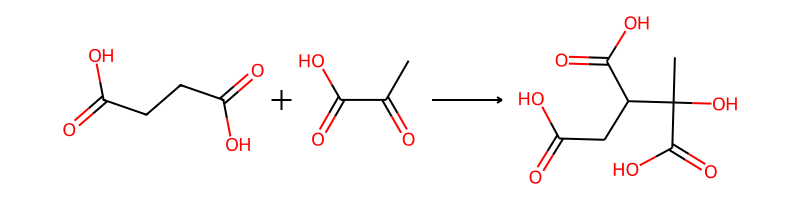

STEP #2
[('rid', 485), ('rhea_ids', [16811, 57506]), ('imt_rules', ['rule0051_08']), ('weight', 1.0), ('requires', {}), ('other_products', {'O=C(O)CCC(=O)O': 1})]


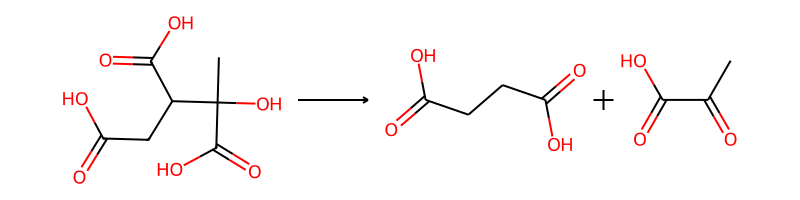

In [71]:
show_path(j, i)

STEP #1
[('rid', 410), ('rhea_ids', [40113]), ('imt_rules', ['rule0059_5']), ('weight', 0.09433962264150944), ('requires', {'CC(C)(COP(=O)(O)OP(=O)(O)OCC1OC(n2cnc3c(N)ncnc32)C(O)C1OP(=O)(O)O)C(O)C(=O)NCCC(=O)NCCS': 1}), ('other_products', {'O': 1})]


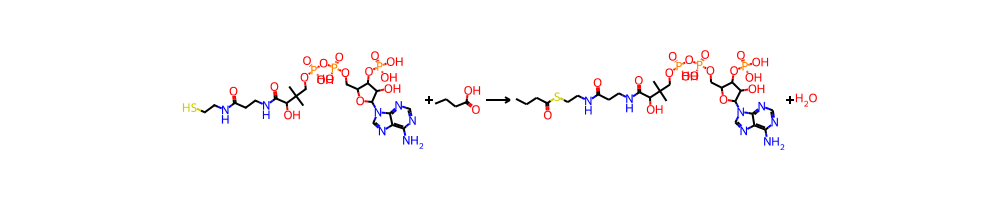

In [72]:
i = G.get_nodes_by_prop('name', 'butanoate')[0]
j  = G.get_nodes_by_prop('name', 'butanoyl-CoA')[0]
show_path(i, j)

STEP #1
[('rid', 12191), ('rhea_ids', [49637]), ('imt_rules', ['rule0145_5']), ('weight', 1.0), ('requires', {'OO': 1}), ('other_products', {'O': 1, 'O=O': 1})]


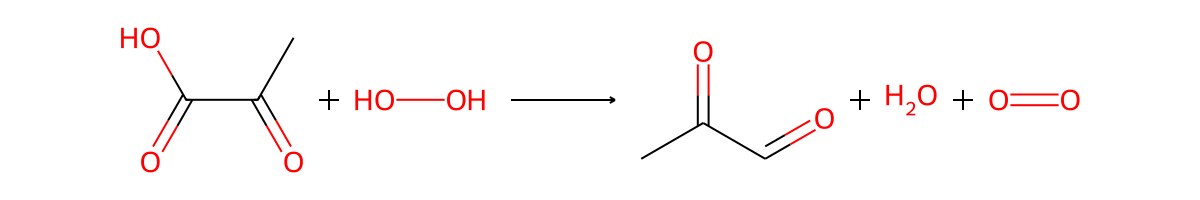

STEP #2
[('rid', 4467), ('rhea_ids', [27987]), ('imt_rules', ['rule0002_143']), ('weight', 1.0), ('requires', {'NC(=O)C1=CN(C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4cnc5c(N)ncnc54)C(OP(=O)(O)O)C3O)C(O)C2O)C=CC1': 1}), ('other_products', {'NC(=O)c1ccc[n+](C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4cnc5c(N)ncnc54)C(OP(=O)(O)O)C3O)C(O)C2O)c1': 1})]


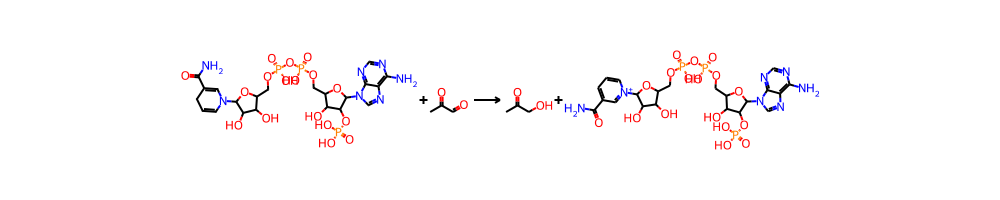

STEP #3
[('rid', 7031), ('rhea_ids', [55790]), ('imt_rules', ['rule0005_60']), ('weight', 1.0), ('requires', {'NC(=O)c1ccc[n+](C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4cnc5c(N)ncnc54)C(O)C3O)C(O)C2O)c1': 1, 'O': 1}), ('other_products', {'NC(=O)C1=CN(C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4cnc5c(N)ncnc54)C(O)C3O)C(O)C2O)C=CC1': 1, 'O=O': 1})]


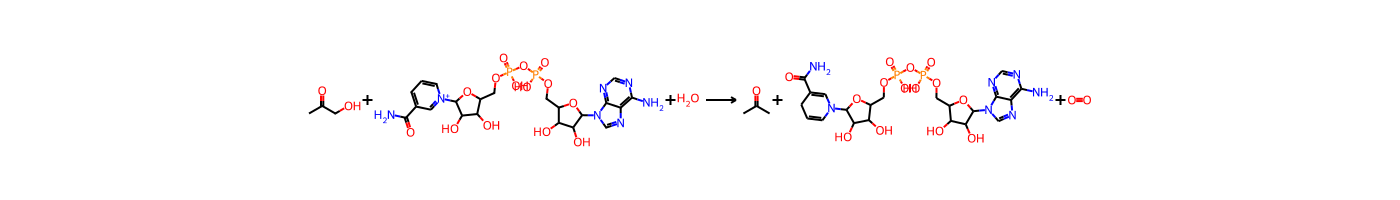

In [81]:
i = G.get_nodes_by_prop('name', 'pyruvate')[0]
j  = G.get_nodes_by_prop('name', 'acetone')[0]
show_path(i, j)

STEP #1
[('rid', 7031), ('rhea_ids', [55790]), ('imt_rules', ['rule0005_60']), ('weight', 0.8), ('requires', {'NC(=O)C1=CN(C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4cnc5c(N)ncnc54)C(O)C3O)C(O)C2O)C=CC1': 1, 'O=O': 1}), ('other_products', {'NC(=O)c1ccc[n+](C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4cnc5c(N)ncnc54)C(O)C3O)C(O)C2O)c1': 1, 'O': 1})]


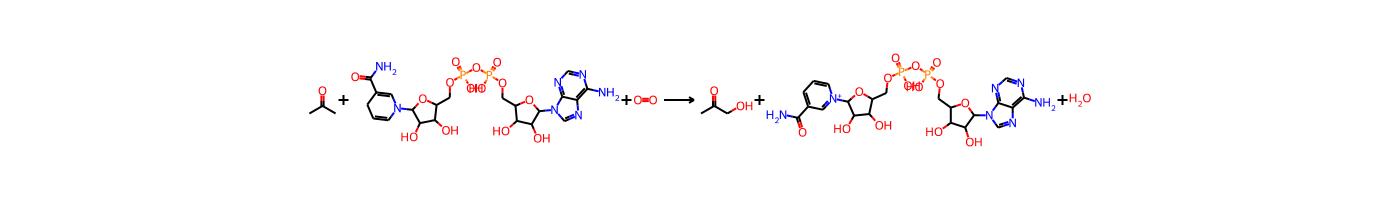

STEP #2
[('rid', 4467), ('rhea_ids', [27987]), ('imt_rules', ['rule0002_143']), ('weight', 1.0), ('requires', {'NC(=O)c1ccc[n+](C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4cnc5c(N)ncnc54)C(OP(=O)(O)O)C3O)C(O)C2O)c1': 1}), ('other_products', {'NC(=O)C1=CN(C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4cnc5c(N)ncnc54)C(OP(=O)(O)O)C3O)C(O)C2O)C=CC1': 1})]


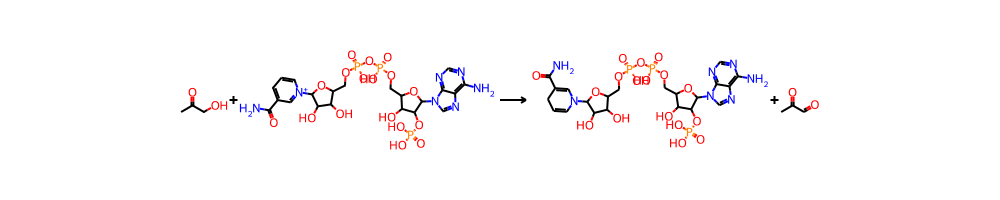

STEP #3
[('rid', 12191), ('rhea_ids', [49637]), ('imt_rules', ['rule0145_5']), ('weight', 0.8333333333333334), ('requires', {'O': 1, 'O=O': 1}), ('other_products', {'OO': 1})]


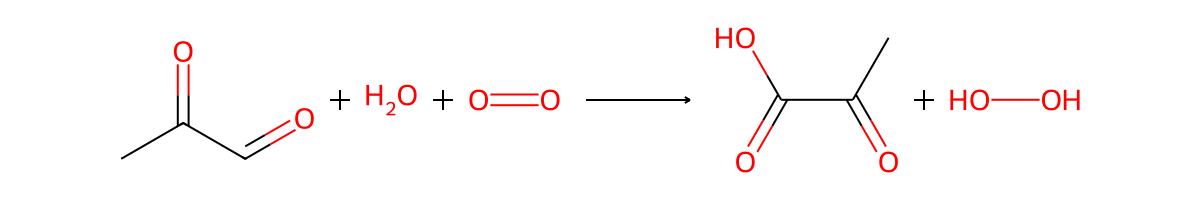

In [82]:
show_path(j, i)

In [ ]:
i = G.get_nodes_by_prop('name', 'pyruvate')[0]
j  = G.get_nodes_by_prop('name', 'L-lysine')[0]
show_path(i, j)

In [ ]:
sorted([node['name'] for id, node in G.nodes(data=True)], key=lambda x : len(x))

In [ ]:
smi = standardize_smiles('CC(C)(CO)[C@@H](O)C(=O)NCCC(=O)[O-]') # CCC(C)(C)C(=O)SCCC(=O)OC
ids = G.get_nodes_by_prop('smiles', smi)
ids

In [ ]:
n = 2
id = ids[0]
n_hop_neighbors = nx.ego_graph(G, id, radius=n)
for i in n_hop_neighbors:
    print(G.nodes[i]['name'])
    display(SVG(draw_molecule(G.nodes[i]['smiles'])))

In [ ]:
for i in n_hop_neighbors:
    print(f"PATH FROM {G.nodes[i]['name']}")
    show_path(i, id)

In [ ]:
DG = nx.DiGraph(G)
DG.number_of_edges(), G.number_of_edges(), DG.number_of_nodes(), G.number_of_nodes(), len(G.edges), len(DG.edges)

In [6]:
import gzip, json
with gzip.open(filepaths['paths'] / "test" / "chunk_1.json.gz", 'rb') as f:
    res = f.read()

res = json.loads(res.decode('utf-8'))

In [7]:
res

{'4312>>2450': [4312, 2450],
 '4294>>4239': [4294, 4239],
 '4239>>4294': [4239, 4294],
 '2933>>2935': [2933, 2935],
 '2935>>2933': [2935, 2933],
 '8045>>8021': [8045, 8021],
 '8021>>8045': [8021, 8045],
 '864>>835': [864, 835]}

In [44]:
paths = nx.shortest_path(G)

<class 'networkx.utils.decorators.argmap'> compilation 4:3: FutureWarning: 

shortest_path will return an iterator that yields
(node, path) pairs instead of a dictionary when source
and target are unspecified beginning in version 3.5

To keep the current behavior, use:

	dict(nx.shortest_path(G))


In [49]:
paths[list(paths.keys())[1]]

{2: [2],
 1936: [2, 1936],
 1469: [2, 1469],
 5899: [2, 1936, 5899],
 8297: [2, 1936, 8297],
 6035: [2, 1936, 6035],
 6799: [2, 1936, 6799],
 6493: [2, 1936, 6493],
 6496: [2, 1936, 6496],
 1154: [2, 1469, 1154],
 325: [2, 1469, 325],
 7162: [2, 1936, 8297, 7162],
 7681: [2, 1936, 8297, 7681],
 8322: [2, 1936, 8297, 8322],
 1542: [2, 1936, 6035, 1542],
 6499: [2, 1936, 6493, 6499],
 1415: [2, 1469, 1154, 1415],
 1414: [2, 1469, 1154, 1414],
 653: [2, 1469, 1154, 653],
 696: [2, 1469, 325, 696],
 326: [2, 1469, 325, 326],
 491: [2, 1469, 325, 491],
 3: [2, 1469, 325, 3],
 474: [2, 1469, 325, 474],
 471: [2, 1469, 325, 471],
 2338: [2, 1469, 325, 2338],
 2450: [2, 1469, 325, 2450],
 470: [2, 1469, 325, 470],
 8220: [2, 1936, 8297, 7681, 8220],
 2400: [2, 1936, 8297, 7681, 2400],
 6916: [2, 1936, 8297, 7681, 6916],
 6599: [2, 1936, 6493, 6499, 6599],
 22: [2, 1469, 1154, 653, 22],
 693: [2, 1469, 1154, 653, 693],
 699: [2, 1469, 1154, 653, 699],
 503: [2, 1469, 1154, 653, 503],
 698: [2, 

In [24]:
from time import perf_counter

In [34]:
V, E, T = [], [], []
for ds in [2**i for i in range(2, 15)]:    
    G = nx.MultiDiGraph()
    G.add_edges_from(edges[:ds])
    V.append(G.number_of_nodes())
    E.append(G.number_of_edges())
    print(G.number_of_nodes(), G.number_of_edges())
    t0 = perf_counter()
    _ = nx.shortest_path(G)
    tf = perf_counter()
    T.append(tf - t0)
    print(tf - t0)

7 4
0.00014573800581274554
12 8
3.688599827000871e-05
21 16
4.1594998037908226e-05
40 32
9.111200051847845e-05
81 64
0.00023305899958359078
152 128
0.000309761002426967
286 256
0.0015689840001869015
551 512
0.00379802800307516
958 1024
0.002993075999256689
1726 2048
0.007766486996843014
2938 4096
0.0329543619955075
4822 8192
0.40401987500081304
7880 16371
9.093195717003255


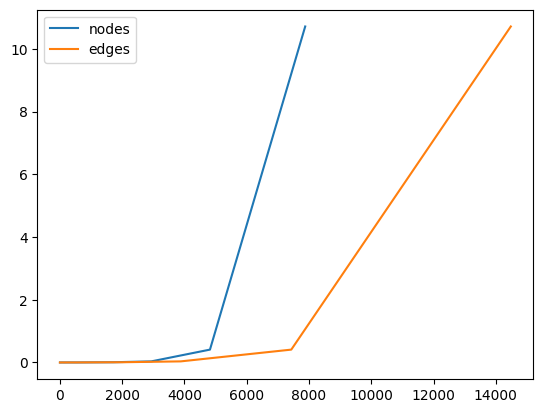

In [32]:
import matplotlib.pyplot as plt

plt.plot(V, T, label="nodes")
plt.plot(E, T, label="edges")
plt.legend()
plt.show()